In [ ]:
# Download the dataset and inspect its structure.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("/content/wave.csv")
features = data[['x', 'y']] # Features
target = data['color'] # Target
data.head()

,x,y,color
0,228.396722,90.875072,0
1,319.395295,81.619745,0
2,162.945088,125.089368,0
3,233.210908,122.902300,0
4,419.122186,334.096431,2


In [ ]:
print(data.isnull().sum()) # Check for missing values

x        0
y        0
color    0
dtype: int64


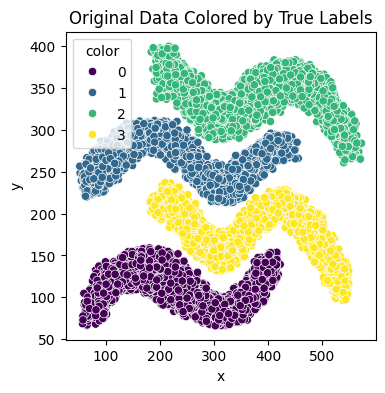

In [ ]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='x', y='y', hue='color', data=data, palette='viridis')
plt.title("Original Data Colored by True Labels")
plt.show()

In [ ]:
# Data preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features) # Scale features
scaled_df = pd.DataFrame(scaled_features, columns=['x_scaled', 'y_scaled'])
scaled_df['color'] = target # Add the target back to the scaled DataFrame
scaled_df.head()

,x_scaled,y_scaled,color
0,-0.614003,-1.429529,0
1,0.143459,-1.531278,0
2,-1.158815,-1.053390,0
3,-0.573931,-1.077434,0
4,0.973574,1.244355,2


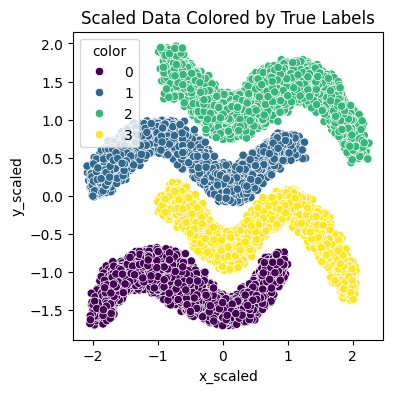

In [ ]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='x_scaled', y='y_scaled', hue='color', data=scaled_df, palette='viridis')
plt.title("Scaled Data Colored by True Labels")
plt.show()

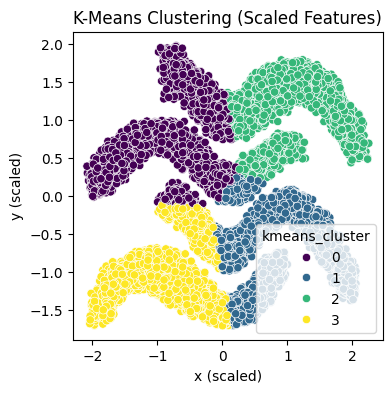

In [ ]:
from sklearn.cluster import KMeans # K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
scaled_df['kmeans_cluster'] = kmeans.fit_predict(scaled_features) # Run K-Means on scaled features
plt.figure(figsize=(4, 4))
sns.scatterplot(x='x_scaled', y='y_scaled', hue='kmeans_cluster', data=scaled_df, palette='viridis')
plt.title('K-Means Clustering (Scaled Features)')
plt.xlabel('x (scaled)')
plt.ylabel('y (scaled)')
plt.show()

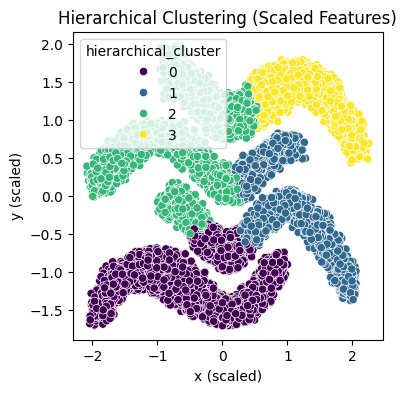

In [ ]:
from sklearn.cluster import AgglomerativeClustering # Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=4)
scaled_df['hierarchical_cluster'] = hierarchical.fit_predict(scaled_features)
plt.figure(figsize=(4, 4))
sns.scatterplot(x='x_scaled', y='y_scaled', hue='hierarchical_cluster', data=scaled_df, palette='viridis')
plt.title('Hierarchical Clustering (Scaled Features)')
plt.xlabel('x (scaled)')
plt.ylabel('y (scaled)')
plt.show()

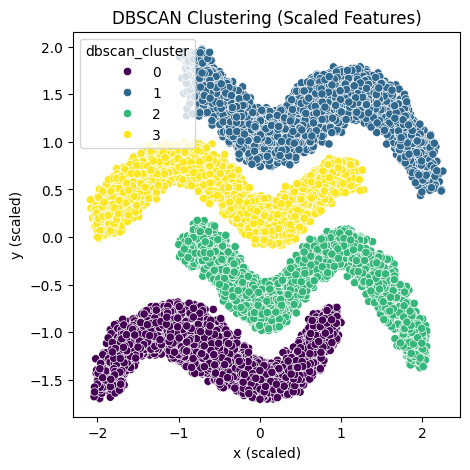

In [ ]:
from sklearn.cluster import DBSCAN # DBSCAN (Density-Based Clustering)
dbscan = DBSCAN(eps=0.11, min_samples=4)
scaled_df['dbscan_cluster'] = dbscan.fit_predict(scaled_features)
plt.figure(figsize=(5, 5))
sns.scatterplot(x='x_scaled', y='y_scaled', hue='dbscan_cluster', data=scaled_df, palette='viridis')
plt.title('DBSCAN Clustering (Scaled Features)')
plt.xlabel('x (scaled)')
plt.ylabel('y (scaled)')
plt.show()

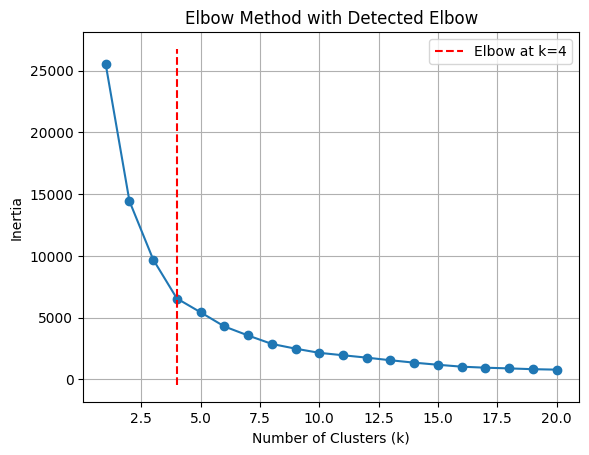

Optimal number of clusters: k = 4
Inertia at k = 4: 6545.50


In [ ]:
!pip install kneed
from kneed import KneeLocator

# Compute inertias for k=1 to 20
inertias = []
k_range = range(1, 21)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)

# Detect elbow
knee = KneeLocator(
    k_range,         # x-values: range of k (number of clusters)
    inertias,        # y-values: inertia values for each k
    curve='convex',  # shape of the curve: inertia typically forms a convex curve
    direction='decreasing'  # direction of the curve: inertia decreases as k increases
)

# Plot the elbow curve with the detected elbow
plt.plot(k_range, inertias, marker='o')
plt.vlines(knee.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='red', label=f"Elbow at k={knee.knee}")
plt.title('Elbow Method with Detected Elbow')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.legend()
plt.show()

# Step 4: Print the optimal k and corresponding inertia
print(f"Optimal number of clusters: k = {knee.knee}")
print(f"Inertia at k = {knee.knee}: {inertias[knee.knee - 1]:.2f}")

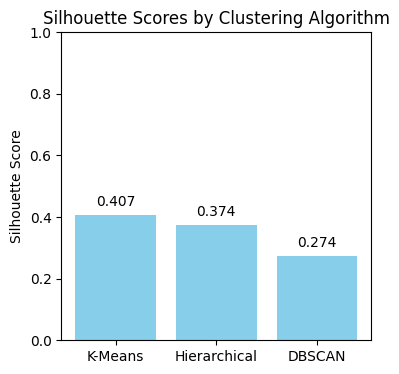

{'K-Means': np.float64(0.4072950325871296),
 'Hierarchical': np.float64(0.37402912837457075),
 'DBSCAN': np.float64(0.2740089106233997)}

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
# Calculate silhouette scores
scores = {}
scores['K-Means'] = silhouette_score(scaled_features, scaled_df['kmeans_cluster'])
scores['Hierarchical'] = silhouette_score(scaled_features, scaled_df['hierarchical_cluster'])
scores['DBSCAN'] = silhouette_score(scaled_features, scaled_df['dbscan_cluster'])
# Plotting
plt.figure(figsize=(4, 4))
plt.bar(scores.keys(), scores.values(), color='skyblue')
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores by Clustering Algorithm")
plt.ylim(0, 1)
for i, (label, score) in enumerate(scores.items()):
    plt.text(i, score + 0.02, f"{score:.3f}", ha='center', va='bottom')
plt.show()
scores

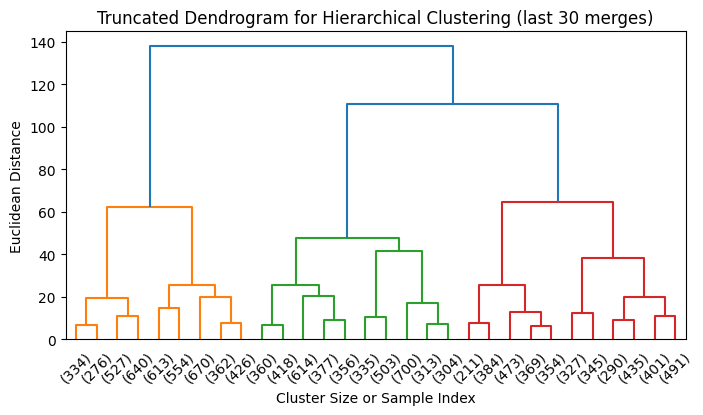

In [ ]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
# Compute the linkage matrix
linkage_matrix = sch.linkage(scaled_features, method='ward')
# Plot the truncated dendrogram
plt.figure(figsize=(8, 4))
dendrogram = sch.dendrogram(linkage_matrix, truncate_mode='lastp', p=30, show_leaf_counts=True)
plt.title("Truncated Dendrogram for Hierarchical Clustering (last 30 merges)")
plt.xlabel("Cluster Size or Sample Index")
plt.ylabel("Euclidean Distance")
plt.show()

In [ ]:
# Import evaluation metrics
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
true_labels = data['color']  # True class labels
results = []  # List to store evaluation results
models = { # Dictionary of clustering model results with predicted cluster labels
    'K-Means': scaled_df['kmeans_cluster'],
    'Hierarchical': scaled_df['hierarchical_cluster'],
    'DBSCAN': scaled_df['dbscan_cluster']
}
# Loop to evaluate clustering performance
for model_name, predicted in models.items():
    # Calculate Silhouette Score if there is more than 1 cluster
    silhouette = silhouette_score(scaled_features, predicted) if len(set(predicted)) > 1 else None
    # Adjusted Rand Index: compares clustering to true labels
    ari = adjusted_rand_score(true_labels, predicted)
    # Normalized Mutual Information: measures information shared between labels and clusters
    nmi = normalized_mutual_info_score(true_labels, predicted)
    # Append results into a dictionary
    results.append({
        'Model': model_name,
        'Silhouette Score': round(silhouette, 3) if silhouette else 'N/A',  # If silhouette couldn't be calculated
        'Adjusted Rand Index (ARI)': round(ari, 3),
        'Normalized Mutual Info (NMI)': round(nmi, 3)
    })
# Convert into a pandas DataFrame
results_df = pd.DataFrame(results)
results_df  # Display

,Model,Silhouette Score,Adjusted Rand Index (ARI),Normalized Mutual Info (NMI)
0,K-Means,0.407,0.399,0.483
1,Hierarchical,0.374,0.471,0.563
2,DBSCAN,0.274,1.000,1.000


In [ ]:
# Compare the clustering outcomes across different methods
from sklearn.metrics import confusion_matrix      # To compute confusion matrices
from scipy.optimize import linear_sum_assignment  # Import Hungarian algorithm for optimal label matching
import pandas as pd                               # For creating a results DataFrame
import numpy as np                                # For array and matrix operations
results = []                # Initialize an empty list to store evaluation results for each model
true_labels = data['color'] # Actual class labels from the original dataset
models = {                  # Dictionary containing model names as keys and their predicted cluster labels as values
    'K-Means': scaled_df['kmeans_cluster'],
    'Hierarchical': scaled_df['hierarchical_cluster'],
    'DBSCAN': scaled_df['dbscan_cluster']
}
for model_name, predicted in models.items():       # Loop over each clustering model
    cm = confusion_matrix(true_labels, predicted)  # Compute confusion matrix comparing true and predicted labels
    # Use Hungarian algorithm to optimally match predicted cluster labels to true labels
    row_ind, col_ind = linear_sum_assignment(-cm)  # -cm is used because the goal is to maximize accuracy
    aligned_cm = cm[:, col_ind]                    # Rearrange the columns of the confusion matrix
    correct = np.trace(aligned_cm)       # Count of correctly clustered samples (sum of the diagonal)
    total = np.sum(aligned_cm)           # Total number of samples
    incorrect = total - correct          # Count of incorrectly clustered samples
    accuracy = correct / total           # Overall clustering accuracy
    results.append({ # Append results into list as a dictionary
        'Model': model_name,
        'Correct': correct,
        'Incorrect': incorrect,
        'Accuracy': round(accuracy, 3)
    })
results_df = pd.DataFrame(results) # Convert into pandas DataFrame
results_df  # Display

,Model,Correct,Incorrect,Accuracy
0,K-Means,8661,4101,0.679
1,Hierarchical,8871,3891,0.695
2,DBSCAN,12762,0,1.000


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from scipy.optimize import linear_sum_assignment
import numpy as np
import pandas as pd

true_labels = data['color']
models = {
    'K-Means': scaled_df['kmeans_cluster'],
    'Hierarchical': scaled_df['hierarchical_cluster'],
    'DBSCAN': scaled_df['dbscan_cluster']
}

all_results = []

for model_name, predicted in models.items():
    # Align cluster labels using Hungarian algorithm
    cm = confusion_matrix(true_labels, predicted)
    row_ind, col_ind = linear_sum_assignment(-cm)
    aligned_preds = [col_ind[label] for label in predicted]

    # Loop through each class to compute metrics
    for cls in np.unique(true_labels):
        # Binary confusion matrix: cls vs rest
        y_true_binary = (true_labels == cls).astype(int)
        y_pred_binary = (np.array(aligned_preds) == cls).astype(int)

        # Compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()
        precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)

        # Append result
        all_results.append({
            'Model': model_name,
            'Class': cls,
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'TN': tn,
            'Precision': round(precision, 3),
            'Recall': round(recall, 3)
        })

# Convert to DataFrame
metrics_df = pd.DataFrame(all_results)
metrics_df

,Model,Class,TP,FP,FN,TN,Precision,Recall
0,K-Means,0,987,2098,2627,7050,0.320,0.273
1,K-Means,1,0,3453,2961,6348,0.000,0.000
2,K-Means,2,2255,720,1047,8740,0.758,0.683
3,K-Means,3,241,3008,2644,6869,0.074,0.084
4,Hierarchical,0,3614,788,0,8360,0.821,1.000
5,Hierarchical,1,0,1791,2961,8010,0.000,0.000
6,Hierarchical,2,0,2289,3302,7171,0.000,0.000
7,Hierarchical,3,700,3580,2185,6297,0.164,0.243
8,DBSCAN,0,3614,0,0,9148,1.000,1.000
9,DBSCAN,1,0,2885,2961,6916,0.000,0.000


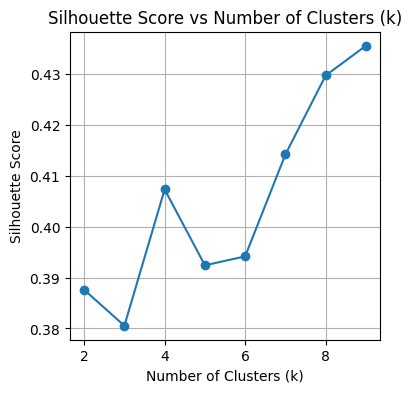

In [ ]:
from sklearn.metrics import silhouette_score
k_values = list(range(2, 10))
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    silhouette_scores.append(score)
plt.figure(figsize=(4, 4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [ ]:
# Step 5: Interpreting and Comparing Models

# Consider factors such as cluster sizes, separation, and real-world meaning.
# Adjust parameters (e.g., number of clusters, distance metrics) to improve results.